In [1]:
import icon_registration.data as data
import icon_registration.networks as networks
import icon_registration.network_wrappers as network_wrappers
import icon_registration.visualize as visualize
import icon_registration.train as train
import icon_registration.config as config
import icon_registration.inverseConsistentNet as inverseConsistentNet
from icon_registration.mermaidlite import compute_warped_image_multiNC
import numpy as np
import torch
import matplotlib.pyplot as plt
import random
import os
import pickle
from IPython.display import Image, display
import torch.nn.functional as F
import icon_registration as icon

def show(t):
    plt.imshow(t.cpu().detach())
    plt.colorbar()
    plt.show()

/playpen-raid1/tgreer/InverseConsistency/src/icon_registration/inverseConsistentNet.py:3: UserWarning: inverseConsistentNet.py is deprecated, its code has been moved to losses.py
        In a future release this file may be deleted.
  warnings.warn(


In [2]:
d1, d2 = data.get_dataset_triangles("train", hollow=True)
d1_t, d2_t = data.get_dataset_triangles("test", hollow=True)

lmbda = .2

In [7]:
inner_net = network_wrappers.FunctionFromVectorField(networks.tallUNet2(dimension=2))

for _ in range(3):
  inner_net = network_wrappers.DoubleNet(network_wrappers.DownsampleNet(inner_net, 2), network_wrappers.FunctionFromVectorField(networks.tallUNet2(dimension=2)))

netGrad = inverseConsistentNet.GradientICON(
    inner_net,
    # Our image similarity metric. The last channel of x and y is whether the value is interpolated or extrapolated, 
    # which is used by some metrics but not this one
    #inverseConsistentNet.LNCC(sigma=5),
    inverseConsistentNet.ssd_only_interpolated,
    .2,
)
input_shape = next(iter(d1))[0].size()
network_wrappers.assignIdentityMap(netGrad, input_shape)
netGrad.cuda()
optimizerGrad = torch.optim.Adam(netGrad.parameters(), lr=0.001)
netGrad.train()
0

/playpen-raid1/tgreer/InverseConsistency/src/icon_registration/network_wrappers.py:220: UserWarning: /tmp/ipykernel_31338/3050033734.py:15 - assignIdentityMap is deprecated. use net.assign_identity_map
  warnings.warn("%s:%d - %s" % (caller.filename, caller.lineno, message))


0

In [8]:
y_grad = np.array(train.train2d(netGrad, optimizerGrad, d1, d2, epochs=30))

 33%|██████████████████████████████████▎                                                                    | 10/30 [03:42<07:24, 22.22s/it]


KeyboardInterrupt: 

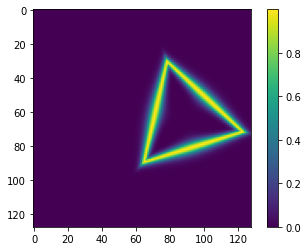

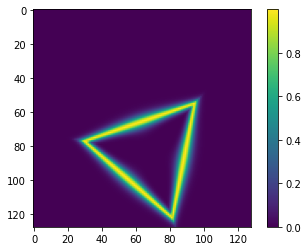

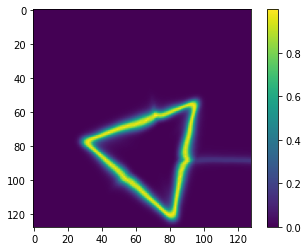

ICONLoss(all_loss=0.006805099546909332, inverse_consistency_loss=0.022012533619999886, similarity_loss=0.0024025929160416126, transform_magnitude=0.016631141304969788, flips=0.0)


In [27]:
netGrad.eval()
image_A, image_B = next(iter(d1))[0], next(iter(d2))[0]
image_A = image_A.cuda()[:1]
image_B = image_B.cuda()[:1]
l_o = netGrad(image_A, image_B)
show(image_A[0, 0])

show(image_B[0, 0])
show(netGrad.warped_image_A[0, 0])
print(icon.losses.to_floats(l_o))

In [28]:
phi_AB_theta = netGrad.phi_AB_vectorfield[:1].detach()
phi_BA_theta = netGrad.phi_BA_vectorfield[:1].detach()

In [29]:
phi_AB = torch.nn.Parameter(phi_AB_theta.clone().detach())
phi_BA = torch.nn.Parameter(phi_BA_theta.clone().detach())
phi_AB_f = lambda x: netGrad.as_function(phi_AB - netGrad.identity_map)(x) + x
phi_BA_f = lambda x: netGrad.as_function(phi_BA - netGrad.identity_map)(x) + x

In [30]:
inversion_optim = torch.optim.Adam([phi_AB, phi_BA], lr=.0001)

In [31]:
for _ in range(3000):
    inversion_optim.zero_grad()
    Iepsilon = (
            netGrad.identity_map
            + torch.randn(*netGrad.identity_map.shape).to(config.device)
            * 1
            / netGrad.identity_map.shape[-1]
        )
    approx_ident = phi_AB_f(phi_BA_f(Iepsilon)) - Iepsilon
    inverse_loss = torch.mean(approx_ident**2)
    other_loss = torch.mean((phi_AB_theta - phi_AB)**2) + torch.mean((phi_BA_theta - phi_BA)**2)
    (inverse_loss + .001 * other_loss).backward()
    
    inversion_optim.step()
print(torch.sqrt(inverse_loss), "inv other", torch.sqrt(other_loss))

tensor(8.6127e-05, device='cuda:0', grad_fn=<SqrtBackward0>) inv other tensor(0.0083, device='cuda:0', grad_fn=<SqrtBackward0>)


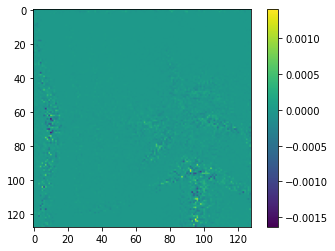

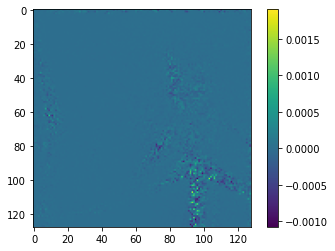

In [32]:
show(approx_ident[0, 1])
show(approx_ident[0, 0])

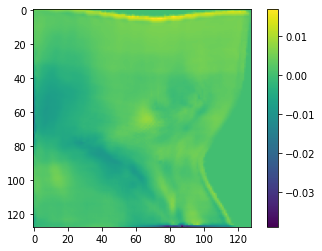

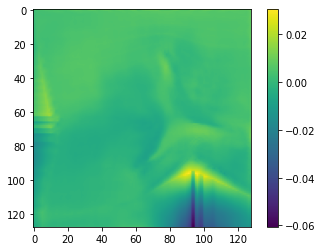

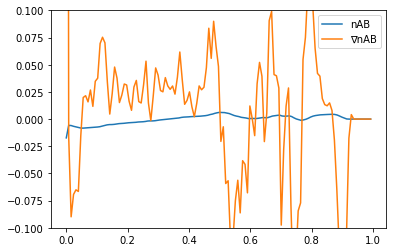

In [33]:
nAB = phi_AB_theta - phi_AB
show(nAB[0, 0])
nBA = phi_BA_theta - phi_BA
show(nBA[0, 0])
plt.plot(np.arange(0, 1, 1/128),nAB[0, 0, 60].detach().cpu(), label="nAB")
plt.plot(np.arange(0, 1, 1/127),
         ((nAB[0, 0, 60, 1:] - nAB[0, 0, 60, :-1])*128).detach().cpu(), label="∇nAB")
plt.ylim(-.1, .1)
plt.legend()

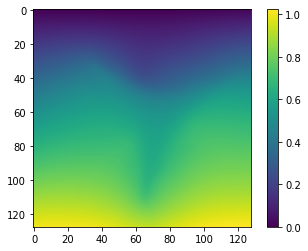

In [353]:
plt.colorbar

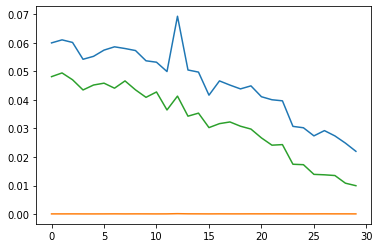

In [459]:
plt.plot(y_grad[:, :3])

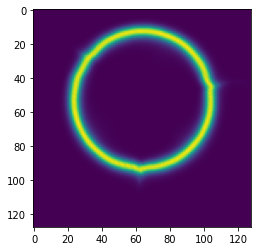

In [55]:
plt.imshow(netGrad.warped_image_A[0, 0].cpu().detach())